<a href="https://colab.research.google.com/github/VietAnh954/Plant-Status-Classification-based-on-Leaf-Color-Features-and-Sensor-Data-ML-/blob/main/4_Final_Dataset_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# [CELL 1] - Import Libraries & Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# Cấu hình giao diện biểu đồ
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

# 2. Đường dẫn file (Theo đúng path bạn cung cấp)
path_leaf = "/content/drive/MyDrive/Colab Notebooks/ML/NEW PLAN/dataPlantVillage/leaf_features_final.csv"
path_sensor_farm = "/content/drive/MyDrive/Colab Notebooks/ML/NEW PLAN/processed_data_2+3/processed_smart_farm.csv"
path_sensor_crop = "/content/drive/MyDrive/Colab Notebooks/ML/NEW PLAN/processed_data_2+3/processed_crop_v2.csv"

print("🔄 Đang load dữ liệu...")

try:
    # Load dữ liệu LÁ (Visual Data)
    df_leaf = pd.read_csv(path_leaf)
    print(f"✅ Load xong dữ liệu Lá: {len(df_leaf)} mẫu.")

    # Load dữ liệu SENSOR (Environmental Data)
    df_s1 = pd.read_csv(path_sensor_farm)
    df_s2 = pd.read_csv(path_sensor_crop)
    print(f"✅ Load xong Sensor 1 (Smart Farm): {len(df_s1)} mẫu.")
    print(f"✅ Load xong Sensor 2 (Crop V2): {len(df_s2)} mẫu.")

except Exception as e:
    print(f"❌ Lỗi load file: {e}")
    print("⚠️ Hãy kiểm tra lại đường dẫn file trên Google Drive!")

Mounted at /content/drive
🔄 Đang load dữ liệu...
✅ Load xong dữ liệu Lá: 7025 mẫu.
✅ Load xong Sensor 1 (Smart Farm): 500 mẫu.
✅ Load xong Sensor 2 (Crop V2): 2200 mẫu.


🛠️ Đang gộp dữ liệu Sensor...
------------------------------
📊 TỔNG KHO SENSOR: 2700 mẫu dữ liệu.
------------------------------
Source
Crop_V2_Dataset       2200
Smart_Farm_Dataset     500
Name: count, dtype: int64


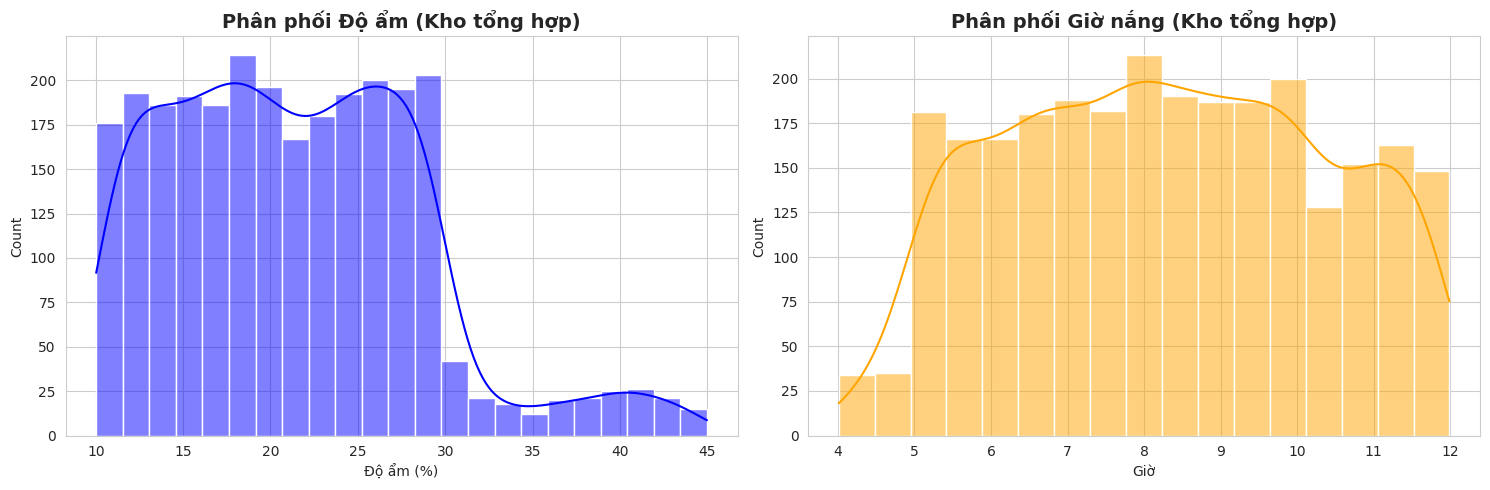

In [ ]:
# [CELL 2] - Create Sensor Pool (Gộp 2 bộ Sensor)
print("🛠️ Đang gộp dữ liệu Sensor...")

# Gộp lại (Concatenate)
sensor_pool = pd.concat([df_s1, df_s2], ignore_index=True)

print("-" * 30)
print(f"📊 TỔNG KHO SENSOR: {len(sensor_pool)} mẫu dữ liệu.")
print("-" * 30)
# Kiểm tra nguồn dữ liệu
print(sensor_pool['Source'].value_counts())

# --- VISUALIZE KHO DỮ LIỆU TỔNG HỢP ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Biểu đồ Độ ẩm
sns.histplot(sensor_pool['Soil_Moisture'], kde=True, color='blue', ax=axes[0])
axes[0].set_title('Phân phối Độ ẩm (Kho tổng hợp)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Độ ẩm (%)')

# Biểu đồ Giờ nắng
sns.histplot(sensor_pool['Sunlight_Hours'], kde=True, color='orange', ax=axes[1])
axes[1].set_title('Phân phối Giờ nắng (Kho tổng hợp)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Giờ')

plt.tight_layout()
plt.show()

In [ ]:
# [CELL 3] - Define Hybridization Logic (Hàm Lai Tạo Logic Master)

# 1. PHÂN LOẠI BỂ CHỨA (SEGMENTATION)
# Chúng ta chia nhỏ kho 2700 mẫu kia thành các "giỏ" nhỏ để dễ nhặt
# - Giỏ Đất Ướt (> 40%): Dành cho cây Tốt hoặc Úng
pool_wet = sensor_pool[sensor_pool['Soil_Moisture'] > 40]

# - Giỏ Đất Hơi Khô (20-40%): Dành cho cây Cần tưới
pool_dry = sensor_pool[(sensor_pool['Soil_Moisture'] >= 20) & (sensor_pool['Soil_Moisture'] <= 40)]

# - Giỏ Đất Rất Khô (< 20%): Dành cho cây Héo
pool_very_dry = sensor_pool[sensor_pool['Soil_Moisture'] < 20]

# - Giỏ Có Bệnh (Disease_Flag = Disease): Dành cho cây Sâu bệnh
pool_disease = sensor_pool[sensor_pool['Disease_Flag'] == 'Disease']

# 2. HÀM LAI TẠO (THE MATCHMAKER FUNCTION)
def hybridize_row(leaf_row):
    """
    Hàm này nhận vào 1 dòng thông tin LÁ (Ảnh) -> Trả về Môi trường tương ứng (Sensor)
    """
    derived_color = leaf_row['Derived_Color'] # Màu từ ảnh: Xanh, Vang, Nau/Dom

    # --- LOGIC 1: LÁ MÀU XANH (Cây Tốt hoặc Cần tưới) ---
    if derived_color == 'Xanh':
        # 60% là Tốt, 40% là Cần tưới (Cây mới khát lá vẫn xanh)
        outcome = np.random.choice(['Tot', 'Can_tuoi'], p=[0.6, 0.4])

        if outcome == 'Tot':
            # Tốt -> Lấy đất ướt
            sample = pool_wet.sample(1).iloc[0] if not pool_wet.empty else sensor_pool.sample(1).iloc[0]
            final_label = 'Tot'
        else:
            # Cần tưới -> Lấy đất hơi khô
            sample = pool_dry.sample(1).iloc[0] if not pool_dry.empty else sensor_pool.sample(1).iloc[0]
            final_label = 'Can_tuoi'

    # --- LOGIC 2: LÁ MÀU VÀNG (Cây Héo hoặc Sâu bệnh) ---
    elif derived_color == 'Vang':
        # 70% là Héo (do thiếu nước lâu ngày), 30% là Bệnh
        outcome = np.random.choice(['Heo', 'Sau_benh'], p=[0.7, 0.3])

        if outcome == 'Heo':
            # Héo -> Lấy đất rất khô
            sample = pool_very_dry.sample(1).iloc[0] if not pool_very_dry.empty else sensor_pool.sample(1).iloc[0]
            final_label = 'Heo'
        else:
            # Sâu bệnh -> Lấy môi trường có áp lực bệnh cao
            sample = pool_disease.sample(1).iloc[0] if not pool_disease.empty else sensor_pool.sample(1).iloc[0]
            final_label = 'Sau_benh'

    # --- LOGIC 3: LÁ MÀU NÂU/ĐỐM (Chắc chắn là Bệnh hoặc Chết khô) ---
    else: # Nau/Dom
        # 80% là Sâu bệnh, 20% là Chết héo
        outcome = np.random.choice(['Sau_benh', 'Heo'], p=[0.8, 0.2])

        if outcome == 'Sau_benh':
            sample = pool_disease.sample(1).iloc[0] if not pool_disease.empty else sensor_pool.sample(1).iloc[0]
            final_label = 'Sau_benh'
        else:
            sample = pool_very_dry.sample(1).iloc[0]
            final_label = 'Heo'

    # Trả về bộ dữ liệu ghép hoàn chỉnh
    return pd.Series({
        'Soil_Moisture': sample['Soil_Moisture'],
        'Sunlight_Hours': sample['Sunlight_Hours'],
        'Final_Label': final_label
    })

print("✅ Đã nạp xong LOGIC LAI TẠO vào bộ nhớ!")
print("👉 Sẵn sàng để chạy ghép dữ liệu ở Cell tiếp theo.")

✅ Đã nạp xong LOGIC LAI TẠO vào bộ nhớ!
👉 Sẵn sàng để chạy ghép dữ liệu ở Cell tiếp theo.


🚀 Đang thực hiện lai tạo dữ liệu (Chờ chút nhé)...
✅ HOÀN TẤT LAI TẠO!
------------------------------
5 dòng đầu tiên của bộ dữ liệu 'Siêu cấp':


,Image_Name,Original_Class,Pct_Green,Pct_Yellow,Pct_Brown,Derived_Color,Soil_Moisture,Sunlight_Hours,Final_Label
0,c9e13908-bce6-4ad7-831f-a4a408cabf72___JR_B.Sp...,Pepper__bell___Bacterial_spot,20.484279,32.461785,15.614432,Nau/Dom,18.830000,6.100000,Sau_benh
1,cc74b411-3662-41cf-9764-517ddfa1e913___NREC_B....,Pepper__bell___Bacterial_spot,28.254640,5.157929,40.013025,Nau/Dom,25.203149,6.433506,Sau_benh
2,02baf62e-11e2-4dde-97fb-e369b57d55d3___JR_B.Sp...,Pepper__bell___Bacterial_spot,90.127891,2.575333,1.094954,Xanh,25.431516,8.984180,Can_tuoi
3,018e494e-d2eb-468b-9d02-40219d9f4921___JR_B.Sp...,Pepper__bell___Bacterial_spot,63.707666,2.925868,4.987892,Nau/Dom,11.836693,8.876882,Sau_benh
4,cbb8c960-5659-4bf1-b75e-f5b2e65b7c0b___NREC_B....,Pepper__bell___Bacterial_spot,61.582585,1.230390,1.316431,Xanh,26.569299,10.980044,Can_tuoi


------------------------------
Thống kê số lượng từng nhãn:
Final_Label
Sau_benh    3765
Tot         1280
Heo         1177
Can_tuoi     803
Name: count, dtype: int64


/tmp/ipython-input-953928062.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_final, x='Final_Label', palette='viridis',


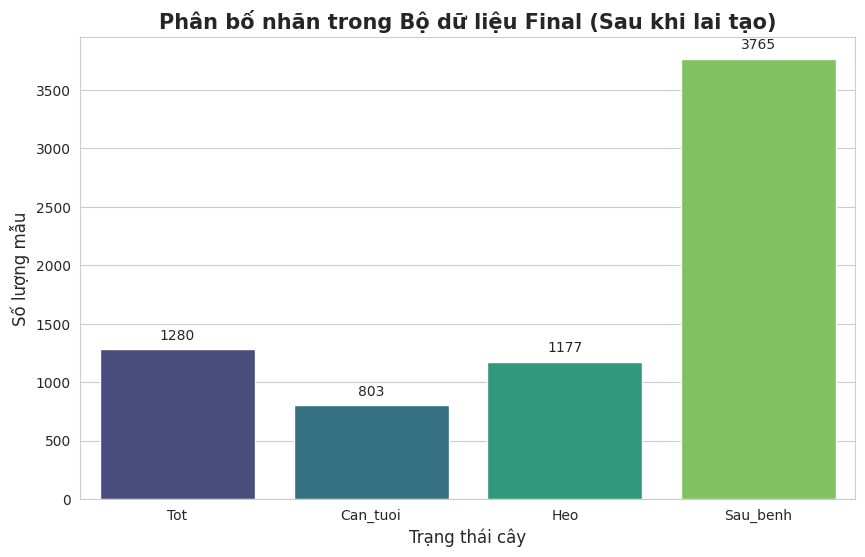

In [ ]:
# [CELL 4] - Execute Hybridization (Thực thi ghép dữ liệu)
print("🚀 Đang thực hiện lai tạo dữ liệu (Chờ chút nhé)...")

# 1. Áp dụng hàm hybridize_row cho từng dòng của df_leaf
# axis=1 nghĩa là xử lý theo chiều ngang (từng dòng một)
hybrid_result = df_leaf.apply(hybridize_row, axis=1)

# 2. Ghép kết quả vào dataframe gốc
# Chúng ta sẽ có: [Thông tin Ảnh] + [Thông tin Sensor + Nhãn Final]
df_final = pd.concat([df_leaf, hybrid_result], axis=1)

print("✅ HOÀN TẤT LAI TẠO!")
print("-" * 30)
print("5 dòng đầu tiên của bộ dữ liệu 'Siêu cấp':")
display(df_final.head())
print("-" * 30)

# 3. Thống kê kết quả
label_counts = df_final['Final_Label'].value_counts()
print("Thống kê số lượng từng nhãn:")
print(label_counts)

# --- VISUALIZE KẾT QUẢ CUỐI CÙNG ---
plt.figure(figsize=(10, 6))
# Vẽ biểu đồ cột để xem độ cân bằng dữ liệu
ax = sns.countplot(data=df_final, x='Final_Label', palette='viridis',
                   order=['Tot', 'Can_tuoi', 'Heo', 'Sau_benh'])

plt.title("Phân bố nhãn trong Bộ dữ liệu Final (Sau khi lai tạo)", fontsize=15, fontweight='bold')
plt.xlabel("Trạng thái cây", fontsize=12)
plt.ylabel("Số lượng mẫu", fontsize=12)

# Hiển thị số liệu trên đầu cột cho chuyên nghiệp
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [ ]:
# [CELL 5] - Export Final Dataset
# Đường dẫn lưu file (Cùng thư mục với các file processed)
output_path = "/content/drive/MyDrive/Colab Notebooks/ML/NEW PLAN/processed_data_2+3/Final_Training_Data.csv"

# Lưu file CSV
df_final.to_csv(output_path, index=False)

print("🎉 CHÚC MỪNG! BẠN ĐÃ TẠO RA BỘ DỮ LIỆU 'SIÊU CẤP' THÀNH CÔNG.")
print(f"💾 File đã lưu tại: {output_path}")
print("=" * 50)
print("Sẵn sàng cho việc Training Model!")

🎉 CHÚC MỪNG! BẠN ĐÃ TẠO RA BỘ DỮ LIỆU 'SIÊU CẤP' THÀNH CÔNG.
💾 File đã lưu tại: /content/drive/MyDrive/Colab Notebooks/ML/NEW PLAN/processed_data_2+3/Final_Training_Data.csv
Sẵn sàng cho việc Training Model!
